## Kaggle Zillow Competition
#### Description: https://www.kaggle.com/c/zillow-prize-1
#### Objective: Build a model to improve the Zestimate residual error.
logerror=log(Zestimate)−log(SalePrice)

## import modules

In [213]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from matplotlib.axes import Subplot

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import pickle
import xgboost
import lightgbm as lgb

from sklearn import linear_model
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error

from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

# Datetime operations
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import ggplot
import warnings
%matplotlib inline

## load data

In [52]:
properties_2016 = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/properties_2016.csv', low_memory = False)
properties_2017 = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/properties_2017.csv', low_memory = False)

train_2016 = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/train_2016_v2.csv', parse_dates=['transactiondate'], low_memory=False)
train_2017 = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/train_2017.csv', parse_dates=['transactiondate'], low_memory=False)

## exploratory analysis

In [40]:
df_train = train_2017  # change to train2017
df_properties = properties_2016

In [41]:
df_train.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


In [54]:
df_train.shape

(77613, 3)

In [55]:
df_properties.shape

(2985217, 58)

In [42]:
df_properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [43]:
df_properties.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


In [44]:
df_train.dtypes

parcelid                    int64
logerror                  float64
transactiondate    datetime64[ns]
dtype: object

In [45]:
df_properties.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,2.985217e+06,811519.000000,6061.000000,1628.000000,2.973755e+06,2.973767e+06,12629.000000,1.938488e+06,2.856305e+06,17096.0,...,2647.000000,2.925289e+06,682069.000000,2.930235e+06,2.942667e+06,2.973778e+06,2.917484e+06,2.953967e+06,56464.000000,2.910091e+06
mean,1.332586e+07,1.931166,7.202607,646.883292,2.209143e+00,3.088949e+00,3.725948,5.784787e+00,2.299263e+00,66.0,...,278.296562,1.964262e+03,1.401464,1.708836e+05,4.204790e+05,2.014999e+03,2.524780e+05,5.377607e+03,13.892409,6.048431e+13
std,7.909966e+06,3.148587,2.436290,538.793473,1.077754e+00,1.275859e+00,0.501700,1.805352e+00,1.000736e+00,0.0,...,369.731508,2.344132e+01,0.539076,4.020683e+05,7.263467e+05,3.683161e-02,4.450132e+05,9.183107e+03,2.581006,3.249035e+11
min,1.071172e+07,1.000000,2.000000,20.000000,0.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,66.0,...,10.000000,1.801000e+03,1.000000,1.000000e+00,1.000000e+00,2.000000e+03,1.000000e+00,1.340000e+00,0.000000,-1.000000e+00
25%,1.164371e+07,1.000000,7.000000,272.000000,2.000000e+00,2.000000e+00,3.000000,4.000000e+00,2.000000e+00,66.0,...,96.000000,1.950000e+03,1.000000,7.480000e+04,1.796750e+05,2.015000e+03,7.483600e+04,2.461070e+03,14.000000,6.037400e+13
50%,1.254509e+07,1.000000,7.000000,534.000000,2.000000e+00,3.000000e+00,4.000000,7.000000e+00,2.000000e+00,66.0,...,168.000000,1.963000e+03,1.000000,1.225900e+05,3.060860e+05,2.015000e+03,1.670420e+05,3.991780e+03,14.000000,6.037572e+13
75%,1.409712e+07,1.000000,7.000000,847.250000,3.000000e+00,4.000000e+00,4.000000,7.000000e+00,3.000000e+00,66.0,...,320.000000,1.981000e+03,2.000000,1.968890e+05,4.880000e+05,2.015000e+03,3.069180e+05,6.201005e+03,15.000000,6.059042e+13
max,1.696019e+08,13.000000,27.000000,8516.000000,2.000000e+01,2.000000e+01,5.000000,1.200000e+01,2.000000e+01,66.0,...,6141.000000,2.015000e+03,41.000000,2.514860e+08,2.827860e+08,2.016000e+03,9.024622e+07,3.458861e+06,99.000000,4.830301e+14


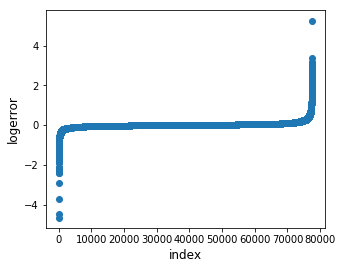

In [46]:
# visualize logerror
plt.figure(figsize=(5,4))
plt.scatter(range(df_train.shape[0]), np.sort(df_train.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

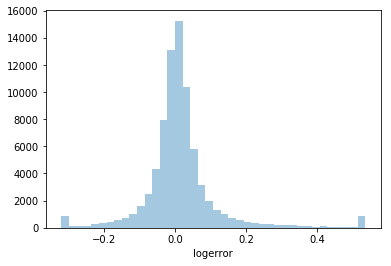

In [47]:
# histogram
ulimit = np.percentile(df_train.logerror.values, 99)
llimit = np.percentile(df_train.logerror.values, 1)
df_train['logerror'].ix[df_train['logerror']>ulimit] = ulimit
df_train['logerror'].ix[df_train['logerror']<llimit] = llimit

plt.figure(figsize=(6,4))
sns.distplot(train_df.logerror.values, bins=40, kde=False)
plt.xlabel('logerror')
plt.show()

In [58]:
# check missing values
df_nan = df_properties.isnull().sum(axis=0).reset_index()
df_nan.head()

,index,0
0,parcelid,0
1,airconditioningtypeid,2173698
2,architecturalstyletypeid,2979156
3,basementsqft,2983589
4,bathroomcnt,11462


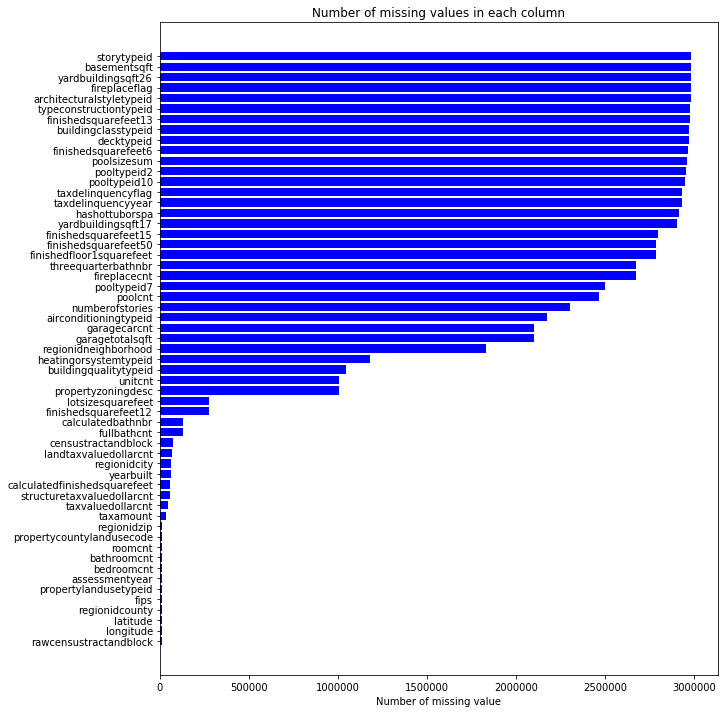

In [59]:
df_nan.columns = ['column_name', 'nan_count']
df_nan = df_nan.ix[df_nan['nan_count']>0]
df_nan = df_nan.sort_values(by='nan_count')

ind = np.arange(df_nan.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,12))
rects = ax.barh(ind, df_nan.nan_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(df_nan.column_name.values, rotation='horizontal')
ax.set_xlabel("Number of missing value")
ax.set_title("Number of missing values in each column")
plt.show()

In [63]:
(df_train['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    77218
2      193
3        3
Name: parcelid, dtype: int64

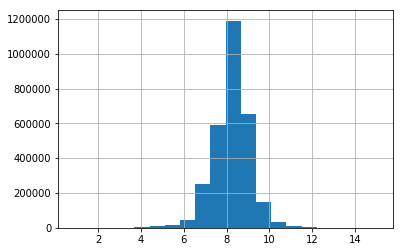

In [64]:
np.log(df_properties.taxamount+1).hist(bins=20)

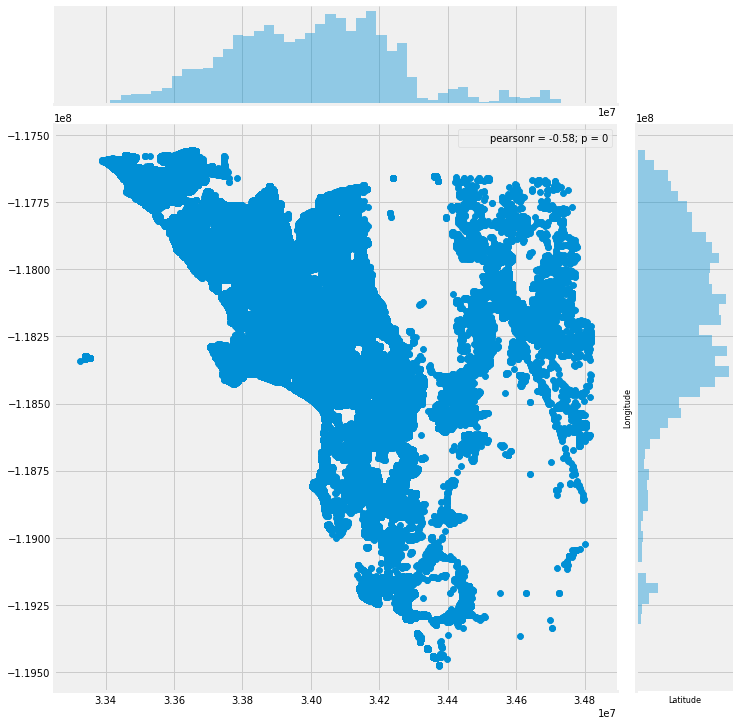

In [127]:
# geographical display
plt.figure(figsize=(8,8))
sns.jointplot(x=df_properties.latitude.values, y=df_properties.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=8)
plt.xlabel('Latitude', fontsize=8)
plt.show()

In [68]:
#check uniqueness of parcelid
df_properties.parcelid.unique().shape[0] == df_properties.parcelid.shape[0]

True

## merge data and clean

In [188]:
df_properties = pd.concat((properties_2016, properties_2017), axis = 0)
df_train = pd.concat((train_2016, train_2017), axis = 0)

df = pd.merge(left=df_properties, right=df_train, on='parcelid')
df_pred = pd.merge(left=df_properties, right=df_train.drop_duplicates(subset='parcelid',keep='first'), on='parcelid', how='left')

In [155]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,...,494390.0,859741.0,2015.0,365351.0,9608.74,NaN,NaN,6.111001e+13,-0.013099,2017-06-15
1,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,...,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,NaN,6.111001e+13,-0.013099,2017-06-15
2,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,...,128881.0,429608.0,2015.0,300727.0,5494.04,NaN,NaN,6.111001e+13,0.073985,2017-07-26
3,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,...,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,NaN,6.111001e+13,0.073985,2017-07-26
4,17068109,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,66.0,...,190508.0,282303.0,2015.0,91795.0,2954.74,NaN,NaN,6.111001e+13,0.071886,2017-07-28


In [118]:
pd.options.display.max_rows = 45

dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,airconditioningtypeid,float64
2,architecturalstyletypeid,float64
3,basementsqft,float64
4,bathroomcnt,float64
5,bedroomcnt,float64
6,buildingclasstypeid,float64
7,buildingqualitytypeid,float64
8,calculatedbathnbr,float64
9,decktypeid,float64


In [119]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,1
1,float64,53
2,datetime64[ns],1
3,object,5


In [120]:
#check null
nan_df = df.isnull().sum(axis=0).reset_index()
nan_df.columns = ['column_name', 'missing_count']
nan_df['missing_ratio'] = nan_df['missing_count'] / train_df.shape[0]
nan_df.ix[nan_df['missing_ratio']>0.99]

,column_name,missing_count,missing_ratio
1,airconditioningtypeid,228153,2.939624
2,architecturalstyletypeid,334840,4.314226
3,basementsqft,335590,4.323889
6,buildingclasstypeid,335713,4.325474
7,buildingqualitytypeid,121399,1.564158
9,decktypeid,333228,4.293456
10,finishedfloor1squarefeet,309925,3.993210
13,finishedsquarefeet13,335626,4.324353
14,finishedsquarefeet15,322602,4.156546
15,finishedsquarefeet50,309925,3.993210


## find correlations 

In [122]:
# impute the missing values with mean values to compute correlation coefficients #
mean_values = df.mean(axis=0)
df_new = df.fillna(mean_values, inplace=True)

In [123]:
# correlation coefficient #
x_cols = [col for col in df_new.columns if col not in ['logerror'] if df_new[col].dtype=='float64']
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df_new[col].values, df_new.logerror.values)[0,1])
df_cor = pd.DataFrame({'col_labels':labels, 'corr_values':values})
df_cor = df_cor.sort_values(by='corr_values')
df_cor_high = df_cor.ix[(df_cor['corr_values']>0.02) | (df_cor['corr_values'] < -0.01)]
df_cor_high 
# shows small correlation 

,col_labels,corr_values
21,heatingorsystemtypeid,-0.012655
50,taxdelinquencyyear,-0.010712
4,bedroomcnt,0.025526
3,bathroomcnt,0.025990
18,fullbathcnt,0.026871
7,calculatedbathnbr,0.028127
10,calculatedfinishedsquarefeet,0.038824
11,finishedsquarefeet12,0.040745


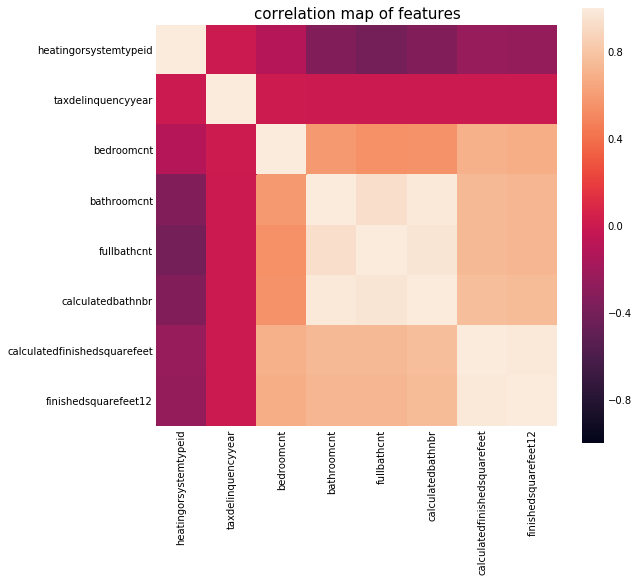

In [129]:
#show correlation map
temp_df = df[df_cor_high.col_labels.tolist()]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmin=-1.,vmax=1., square=True)
plt.title("correlation map of features", fontsize=15)
plt.show()

## check and convert features

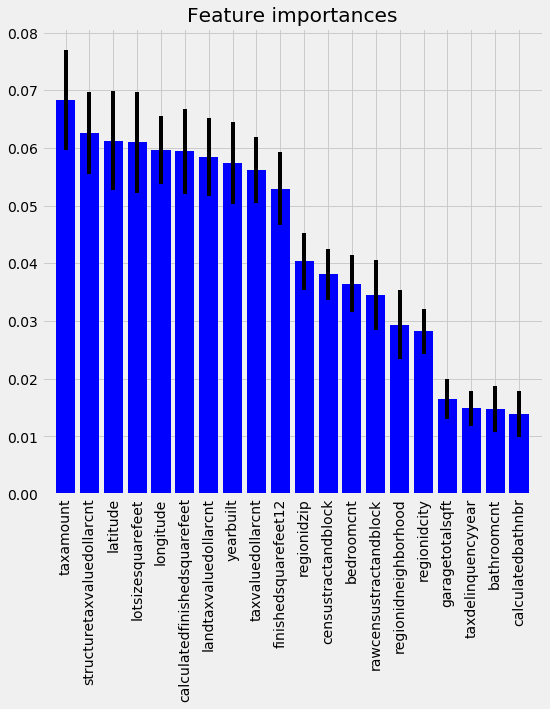

In [176]:
# find import features to model
#df = pd.merge(left=df_properties, right=df_train, on='parcelid')
df1 = df.fillna(df.mean(axis=0), inplace=True)
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
df1 = df1.drop(['parcelid', 'logerror', 'transactiondate']+cat_cols, axis=1)
feat_names = df1.columns.values

from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(df1, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8,8))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
# top 10 features from Extra Trees modeltaxamount, structuretaxvaluedollarcnt, lattitude, lotsizesquerefeet, longitude,
#calculatedfinishedsquerefeet, landtaxvaluedollarcnt, yearbuilt, taxvaluedollarcnt, finishedsquerefeet12

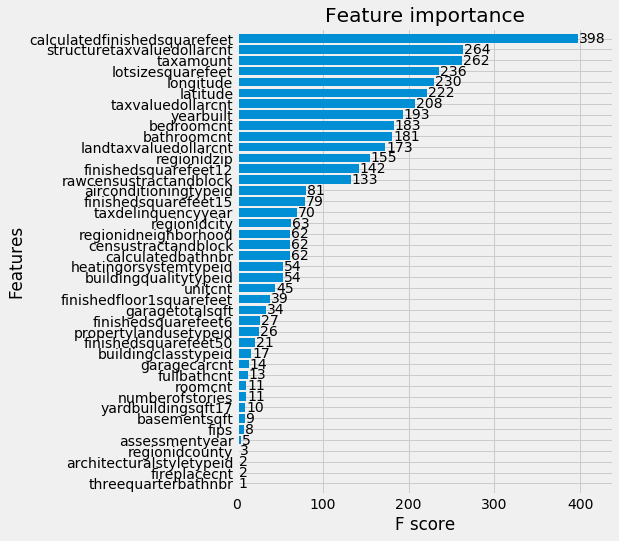

In [181]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df, train_y, feature_names=df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)
feature_importance = pd.DataFrame(model.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)

# plot the important features #
fig, ax = plt.subplots(figsize=(6,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [185]:
# list top 10 features
feature_importance.head(15)

,feature,importance
12,calculatedfinishedsquarefeet,398
9,structuretaxvaluedollarcnt,264
19,taxamount,262
40,lotsizesquarefeet,236
35,longitude,230
14,latitude,222
37,taxvaluedollarcnt,208
5,yearbuilt,193
16,bedroomcnt,183
26,bathroomcnt,181


In [191]:
# define features
all_fields = set(df.columns)

# these are fields that are used to identify fields
identifiers = set(['transactiondate', 'parcelid'])

# log error that we want to model
label = set(['logerror'])

# the following are categorical features
feats_objects = set(df.columns[df.dtypes==object])
#  ['taxdelinquencyflag',
#  'propertycountylandusecode',
#  'propertyzoningdesc',
#  'fireplaceflag',
#  'hashottuborspa']

# the following are numerical features that should be treated as categorical features
feats_numeric_to_categorical = set([
    'airconditioningtypeid',
    'architecturalstyletypeid',
    'buildingqualitytypeid',
    'buildingclasstypeid',
    'decktypeid',
    'fips',
    'heatingorsystemtypeid',
    'propertylandusetypeid',
    'regionidcounty',
    'regionidcity',
    'regionidzip',
    'regionidneighborhood',
    'storytypeid',
    'typeconstructiontypeid',
    'yearbuilt',
    'assessmentyear',
    'taxdelinquencyyear'
])


# the rest are numeric features
feats_numeric = set([
    'basementsqft',
    'bathroomcnt',
    'bedroomcnt',
    'calculatedbathnbr',
    'threequarterbathnbr',
    'finishedfloor1squarefeet',
    'calculatedfinishedsquarefeet',
    'finishedsquarefeet6',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'fireplacecnt',
    'fullbathcnt',
    'garagecarcnt',
    'garagetotalsqft',
    'hashottuborspa',
    'lotsizesquarefeet',
    'numberofstories',
    'poolcnt',
    'poolsizesum',
    'pooltypeid10',
    'pooltypeid2',
    'pooltypeid7',
    'roomcnt',
    'unitcnt',
    'yardbuildingsqft17',
    'yardbuildingsqft26',
    'taxvaluedollarcnt',
    'structuretaxvaluedollarcnt',
    'landtaxvaluedollarcnt',
    'taxamount'
])

# fields that are thrown away for now
feats_for_consideration_later = set([
    'latitude',
    'longitude',
    'rawcensustractandblock',
    'censustractandblock',
])

In [192]:
feats_categorical = feats_numeric_to_categorical | feats_objects
feats_numeric = feats_numeric
feats = feats_categorical | feats_numeric

feats_categorical = list(feats_categorical)
feats_numeric = list(feats_numeric)
feats = list(feats)

In [193]:
# need to impute all these with a `missing` value first
df[feats_categorical] = df[feats_categorical].fillna('--unknown--')
df_pred[feats_categorical] = df_pred[feats_categorical].fillna('--unknown--')

In [194]:
# use label encoder to encode all categorical variables
le = LabelEncoder()
for feat in feats_categorical:
    df_pred[[feat]] = df_pred[[feat]].apply(le.fit_transform)
    df[[feat]] = df[[feat]].apply(le.transform)

In [196]:
# impute missing values for numeric values
imp =  Imputer(missing_values=np.nan,strategy="median",axis=0)

df_pred[feats_numeric] = imp.fit_transform(df_pred[feats_numeric])
df[feats_numeric] = imp.transform(df[feats_numeric])

## split data

In [197]:
mask_train = df.transactiondate < '2016-10-01'
# mask_test_oct = (df.transactiondate >= '2016-10-01') & (df.transactiondate < '2016-11-01')
# mask_test_nov = (df.transactiondate >= '2016-11-01') & (df.transactiondate < '2016-12-01')
# mask_test_dec = (df.transactiondate >= '2016-12-01') & (df.transactiondate < '2017-01-01')
# mask_test = mask_test_oct | mask_test_nov | mask_test_dec
mask_test = (df.transactiondate >= '2016-10-01')

In [198]:
X_train = df.loc[mask_train, feats].astype(float).values
X_test = df.loc[mask_test, feats].astype(float).values

y_train = np.array(df.loc[mask_train, 'logerror'].tolist())
y_test = np.array(df.loc[mask_test, 'logerror'].tolist())

data = (X_train, X_test, y_train, y_test)

In [200]:
# save data
pickle.dump(data, open('/Users/fangjie/Workspace/data-science/competitions/zillow/training_and_testing_data.pkl', 'w'))

## Train a lightgbm model

In [201]:
d_train = lgb.Dataset(X_train, label=y_train)

In [202]:
params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.345    
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

print("\nFitting LightGBM model ...")
clf = lgb.train(params, d_train, 430)


Fitting LightGBM model ...


In [203]:
y_pred = clf.predict(X_test)

In [204]:
explained_variance_score(y_pred=y_pred, y_true=y_test)

0.0055528892410485753

In [205]:
mean_absolute_error(y_pred=y_pred, y_true=y_test)

0.069234296077153742

## train a XGboost regressor

In [206]:
xgb = xgboost.XGBRegressor(n_estimators=200, 
                           #colsample_bytree=1, 
                           max_depth=3, 
                           #reg_alpha=0.001,
                           objective='reg:linear'
                          )

In [207]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [208]:
y_pred = xgb.predict(X_test)

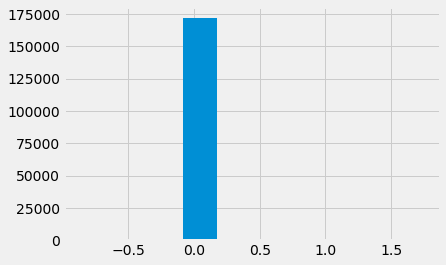

In [209]:
pd.Series(y_pred).hist()

In [210]:
explained_variance_score(y_pred=y_pred, y_true=y_test)

-0.007166430703933413

In [211]:
mean_absolute_error(y_pred=y_pred, y_true=y_test)

0.070236517763752171

In [212]:
xgb.fit(np.concatenate((X_train, X_test), axis=0),np.concatenate((y_train, y_test), axis = 0))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## train a simple elastic net model

In [214]:
alphas = np.logspace(-5, 1, 5)
enet = linear_model.ElasticNet(l1_ratio=0.7)
train_errors = list()
test_errors = list()
for alpha in alphas:
    print 'fitting enet with alpha={} ..'.format(alpha)
    enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
    train_errors.append(enet.score(X_train, y_train))
    test_errors.append(enet.score(X_test, y_test))
    

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

fitting enet with alpha=1e-05 ..
fitting enet with alpha=0.000316227766017 ..
fitting enet with alpha=0.01 ..
fitting enet with alpha=0.316227766017 ..
fitting enet with alpha=10.0 ..
Optimal regularization parameter : 1e-05


In [215]:
test_errors

[0.0012773747404711822,
 0.0012201603208520373,
 0.00088801938672011804,
 0.0006931679151018777,
 -0.0015882030838276773]

In [216]:
# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit( np.concatenate((X_train, X_test), axis=0),np.concatenate((y_train, y_test), axis = 0)).coef_

In [217]:
coef_

array([  7.18463405e-06,  -3.23427230e-03,   1.34716472e-03,
         1.82964628e-05,   5.15070264e-06,   2.03172645e-05,
        -4.68739007e-03,  -2.32071511e-05,   0.00000000e+00,
        -2.62769961e-03,  -1.17394688e-01,   0.00000000e+00,
         0.00000000e+00,  -6.35258698e-08,  -1.24773858e-06,
        -2.63720558e-05,   3.23430667e-06,   0.00000000e+00,
         7.68391523e-06,  -7.56266479e-03,   1.05880943e-02,
         3.10035193e-04,   4.12691995e-04,  -2.62385956e-05,
         9.70931784e-05,   1.59365435e-02,  -2.01685175e-06,
         2.15067162e-05,  -2.29921537e-05,  -4.29033731e-04,
         1.27594301e-03,  -8.79796906e-05,   2.27771097e-06,
        -1.98225707e-03,   6.60013528e-03,   5.43831164e-04,
         4.65946133e-04,  -5.97146868e-03,  -0.00000000e+00,
        -7.84077791e-06,   1.35071877e-03,   1.02127502e-03,
        -1.59627465e-05,   4.21066964e-03,  -5.26581008e-08,
         6.83278542e-08,   7.12655034e-06,   0.00000000e+00,
        -6.74674705e-06,

## geography/spatial parameter 

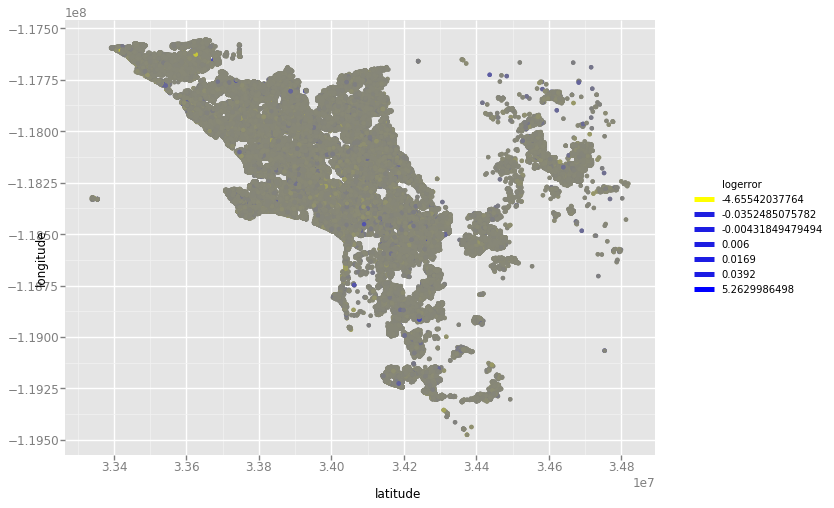

<ggplot: (298472341)>

In [222]:
# geographical logerror distribution
from ggplot import *
ggplot(aes(x='latitude', y='longitude', color='logerror'), data=df) + \
    geom_point() + \
    scale_color_gradient(low = 'yellow', high = 'blue')

## time series analysis, ARIMA

In [223]:
df['transaction_month'] = df['transactiondate'].dt.month
df['transaction_year'] = df['transactiondate'].dt.year
df['transaction_year_and_month'] = df['transactiondate'].astype('str').str[:7]

In [224]:
# train.set_index(pd.to_datetime(train.transactiondate), inplace = True)
df['transactiondate'] = pd.to_datetime(df.transactiondate)

In [225]:
mask = (df['transactiondate'] < '2017-10-01')
df1=df.loc[mask]

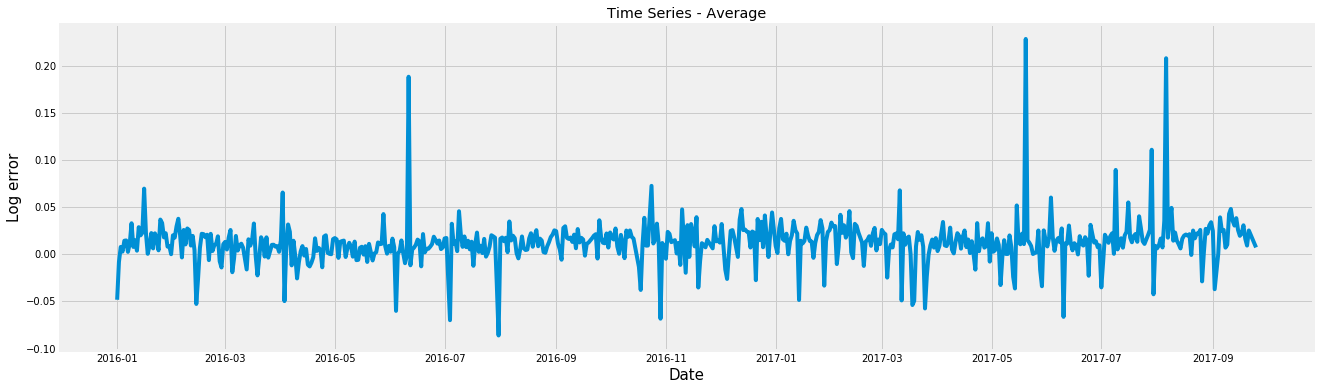

In [226]:
plt.figure(figsize=(20, 6))
mean_group = df1[['transactiondate','logerror']].groupby(['transactiondate'])['logerror'].mean()
plt.plot(mean_group)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Log error', fontsize=15)
plt.title('Time Series - Average')
plt.show() 


In [256]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]
# 12 months, 3, quarter
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 3)
SARIMAX: (0, 0, 1) x (0, 1, 0, 3)
SARIMAX: (0, 1, 0) x (0, 1, 1, 3)
SARIMAX: (0, 1, 0) x (1, 0, 0, 3)


In [257]:
# Akaike Information Criter AIC test
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(mean_group,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 3)12 - AIC:-2731.4595108
ARIMA(0, 0, 0)x(0, 1, 1, 3)12 - AIC:-2836.54814083
ARIMA(0, 0, 0)x(1, 0, 0, 3)12 - AIC:-2748.04993648
ARIMA(0, 0, 0)x(1, 0, 1, 3)12 - AIC:-2851.40159952
ARIMA(0, 0, 0)x(1, 1, 0, 3)12 - AIC:-2618.80077034
ARIMA(0, 0, 0)x(1, 1, 1, 3)12 - AIC:-2833.38938695
ARIMA(0, 0, 1)x(0, 0, 0, 3)12 - AIC:-2747.98290652
ARIMA(0, 0, 1)x(0, 0, 1, 3)12 - AIC:-2747.16420371
ARIMA(0, 0, 1)x(0, 1, 0, 3)12 - AIC:-2454.19993605
ARIMA(0, 0, 1)x(0, 1, 1, 3)12 - AIC:-2830.07375039
ARIMA(0, 0, 1)x(1, 0, 0, 3)12 - AIC:-2764.19480911
ARIMA(0, 0, 1)x(1, 0, 1, 3)12 - AIC:-2845.01452625
ARIMA(0, 0, 1)x(1, 1, 0, 3)12 - AIC:-2618.59967442
ARIMA(0, 0, 1)x(1, 1, 1, 3)12 - AIC:-2827.46811445
ARIMA(0, 1, 0)x(0, 0, 1, 3)12 - AIC:-2463.8584728
ARIMA(0, 1, 0)x(0, 1, 1, 3)12 - AIC:-2435.45436737
ARIMA(0, 1, 0)x(1, 0, 0, 3)12 - AIC:-2468.84719629
ARIMA(0, 1, 0)x(1, 0, 1, 3)12 - AIC:-2461.9968641
ARIMA(0, 1, 0)x(1, 1, 0, 3)12 - AIC:-2224.67212524
ARIMA(0, 1, 0)x(1, 1, 1, 3)12 - AI

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0569      0.051      1.109      0.267      -0.044       0.158
ar.L2         -0.2181      0.035     -6.191      0.000      -0.287      -0.149
ma.L1         -1.9992      0.178    -11.221      0.000      -2.348      -1.650
ma.L2          0.9995      0.178      5.610      0.000       0.650       1.349
ar.S.L12      -0.4727      0.172     -2.751      0.006      -0.809      -0.136
ar.S.L24      -0.1319      0.098     -1.339      0.180      -0.325       0.061
ma.S.L12      -1.1535      0.162     -7.103      0.000      -1.472      -0.835
ma.S.L24       0.1700      0.181      0.941      0.347      -0.184       0.524
sigma2         0.0008      0.000      5.691      0.000       0.001       0.001


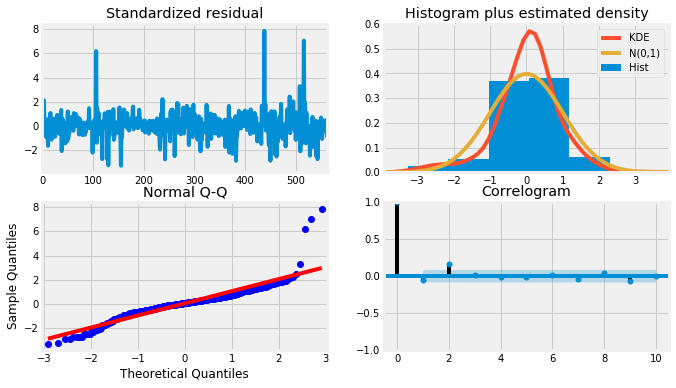

In [285]:
mod = sm.tsa.statespace.SARIMAX(mean_group.values,
                                order=(2, 2, 2),
                                seasonal_order=(2, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
results.plot_diagnostics(figsize=(10, 6))
plt.show()

## ARIMA: prediction

In [286]:
pred = results.get_prediction(start=0,dynamic=False)

In [287]:
y_forecasted = pred.predicted_mean
y_truth = mean_group[0:]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))

The Mean Squared Error of our forecasts is 0.0011


## ARIMA: forcasting

In [288]:
pred_uc=results.get_forecast(steps=97)

In [289]:
forcast = pd.DataFrame( pred_uc.predicted_mean ) 

In [290]:
new_transactiondate = pd.date_range('2017-09-26', periods=97, freq='1D')

In [291]:
columns=[['transactiondate','logerror']]
forcast_from_oct17=pd.DataFrame(columns=columns)

forcast_from_oct17['transactiondate']=new_transactiondate
forcast_from_oct17['logerror']=forcast
forcast_from_oct17.dropna()
forcast_from_oct17.tail()

,transactiondate,logerror
92,2017-12-27,0.045918
93,2017-12-28,0.024712
94,2017-12-29,0.042918
95,2017-12-30,0.046350
96,2017-12-31,0.067430


In [292]:
logerrors=pd.DataFrame( pred.predicted_mean ) 

prediction=pd.DataFrame(columns=columns)

prediction['transactiondate']=pd.to_datetime(mean_group.index)

prediction['logerror'] = logerrors

prediction.head()

,transactiondate,logerror
0,2016-01-01,0.000000
1,2016-01-02,-0.087430
2,2016-01-03,0.034127
3,2016-01-04,0.018855
4,2016-01-05,-0.001302


In [293]:
data=pd.concat([prediction, forcast_from_oct17])
data.head()

,transactiondate,logerror
0,2016-01-01,0.000000
1,2016-01-02,-0.087430
2,2016-01-03,0.034127
3,2016-01-04,0.018855
4,2016-01-05,-0.001302


In [294]:
data.to_csv('/Users/fangjie/Workspace/data-science/competitions/arima_model_month.csv', index=False, float_format='%.6f') 

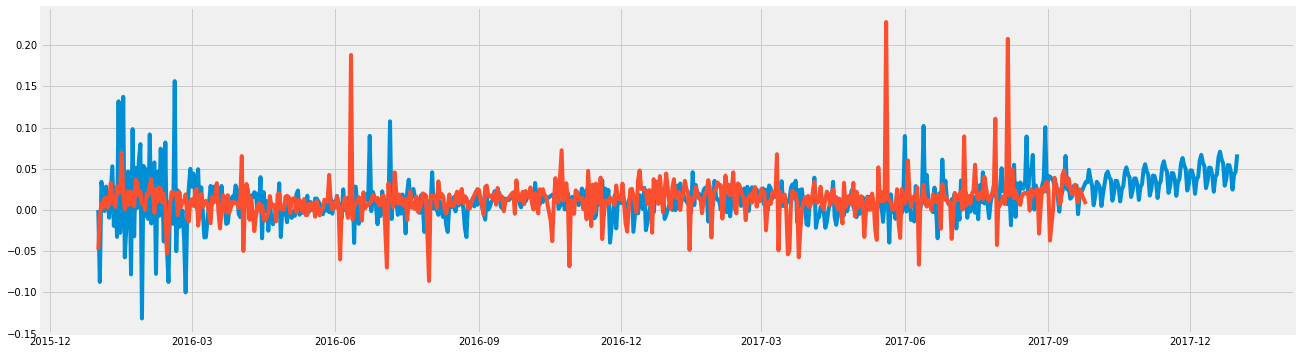

In [295]:
plt.figure(figsize=(20, 6))
xx=data.transactiondate
yy=data.logerror
plt.plot(xx, yy)
plt.plot(mean_group)

## CatBoost

In [ ]:
cat_feature_inds = []
cat_unique_thresh = 1000
for i, c in enumerate(feats_categorical):
    num_uniques = len(df[c].unique())
    if num_uniques < cat_unique_thresh \
       and not 'sqft' in c \
       and not 'cnt' in c \
       and not 'nbr' in c \
       and not 'number' in c:
        cat_feature_inds.append(i)

In [ ]:
num_ensembles = 5
y_pred = 0.0
for i in tqdm(range(num_ensembles)):
    model = CatBoostRegressor(
        iterations=300, learning_rate=0.03,
        depth=6, l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=i)
    
    model.fit(
        X_train, y_train,
        #cat_features=cat_feature_inds
    )
    y_pred += model.predict(X_test)
y_pred /= num_ensembles

In [ ]:
report_test_set_performance()

## Ensemble, bagging

In [ ]:
model_weights = {
    'light_gbm': 1,
    'xgboost': 0.00,
    'elastic_net': 0.1,
    'baseline': 0.001,
}

In [ ]:
pred_all = \
    (pred_lgb * model_weights['light_gbm'] + \
    pred_xgb * model_weights['xgboost'] +\
    pred_rf * model_weights['random_forest'] +\
    pred_enet * model_weights['elastic_net'] +\
    df.logerror.mean() * model_weights['baseline']) / sum(model_weights.values())

## submission

In [62]:
# check directory
from subprocess import check_output
print(check_output(["ls", "/Users/fangjie/Workspace/data-science/competitions/zillow"]).decode("utf8"))

notebooks
properties_2016.csv
properties_2017.csv
sample_submission.csv
sql_scripts
train_2016_v2 2.csv
train_2016_v2.csv
train_2017.csv
virtualenv_requirements.txt



In [ ]:
sample_submission = pd.read_csv('/Users/fangjie/Workspace/data-science/competitions/zillow/sample_submission.csv',low_memory = False)

In [ ]:
sample_submission.head()

In [13]:
df_submission = df[['parcelid','logerror']]
df_submission['pred'] = pred_all

NameError: name 'df' is not defined

In [ ]:
df_submission['201610'] = df_submission['pred']
df_submission['201611'] = df_submission['pred']
df_submission['201612'] = df_submission['pred']
df_submission['201710'] = df_submission['pred']
df_submission['201711'] = df_submission['pred']
df_submission['201712'] = df_submission['pred']

In [ ]:
df_submission.drop_duplicates(subset = ['parcelid'], keep='first', inplace = True)

In [ ]:
del df_submission['logerror']
del df_submission['pred']

In [ ]:
df_submission.shape[0] == 2985217

In [ ]:
df_submission.to_csv('/Users/fangjie/Downloads/submission_{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)